# 불균형 데이터 처리_이미지 증강 & CLASS WEIGHT
- ImageDataGenerator를 사용하여 이미지 증강
- class_weigh 클래스 가중치 부여
- ImageDataGenerator를 사용하여 이미지 증강을 적용하고, 클래스 가중치를 계산하여 fit() 함수에 class_weight 인자로 전달, 이를 통해 데이터 불균형을 처리하고 모델 훈련

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from PIL import Image

from sklearn.utils.class_weight import compute_class_weight

In [ ]:
train_dir = "/content/drive/MyDrive/team_project(DL)/DATA/emotion/train" #passing the path with training images
test_dir = "/content/drive/MyDrive/team_project(DL)/DATA/emotion/test"   #passing the path with testing images

In [ ]:
img_size = 48 #original size of the image

In [ ]:
# 이미지 조회 함수
def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
    plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.tight_layout()
        plt.axis('off')
        plt.imshow(img, cmap='gray')

In [ ]:
plot_images(train_dir+'/angry')

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/User/Downloads/emotion/train/angry'

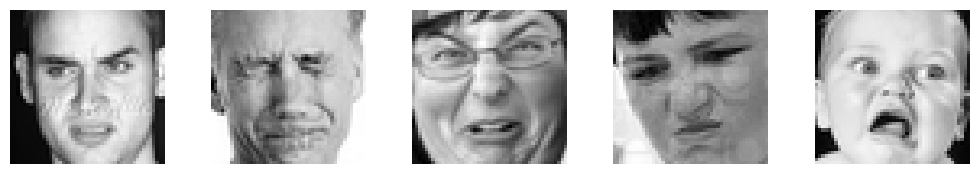

In [ ]:
plot_images(train_dir+'/disgusted')

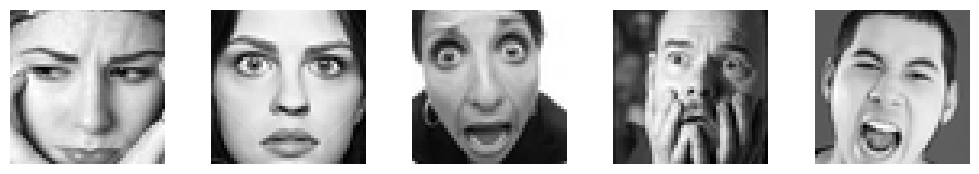

In [ ]:
plot_images(train_dir+'/fearful')

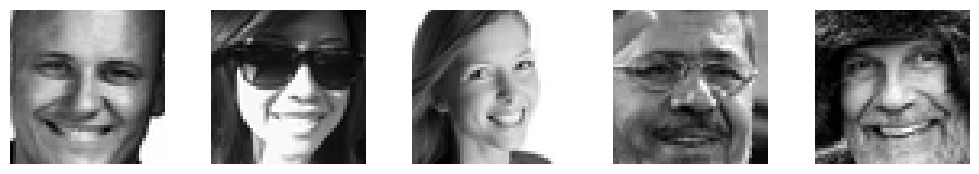

In [ ]:
plot_images(train_dir+'/happy')

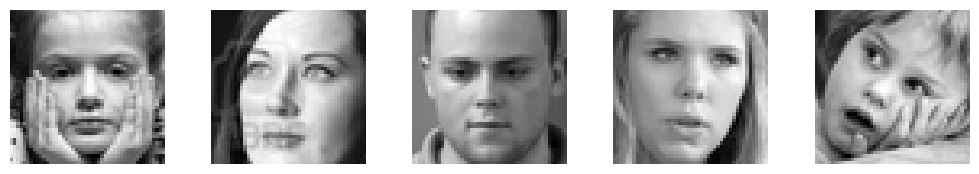

In [ ]:
plot_images(train_dir+'/neutral')

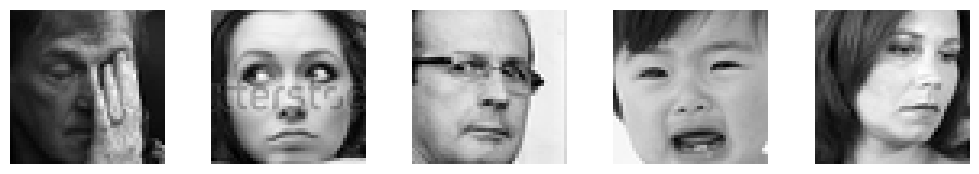

In [ ]:
plot_images(train_dir+'/sad')

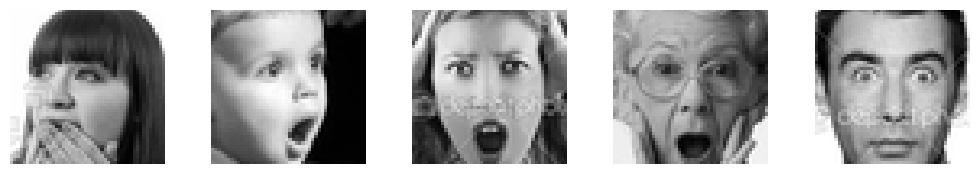

In [ ]:
plot_images(train_dir+'/surprised')

In [ ]:
# 컬럼 분포 조회 함수
def plot_bar_chart_diagram(path_data):
  dic={}
  for emotion in  os.listdir(path_data):
    dem=0
    for x in os.listdir(path_data+"/"+emotion):
      dem+=1
    dic[emotion]=dem
  print(dic)
  barlist=plt.bar(range(len(dic)), list(dic.values()),tick_label=list(dic.keys()))
#set color
  plt.show()

{'angry': 3995, 'disgusted': 436, 'fearful': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprised': 3171}


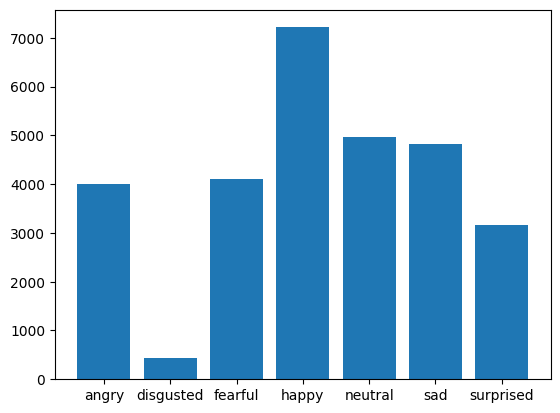

In [ ]:
# TRAIN 이미지 분포 조회
plot_bar_chart_diagram(train_dir)

{'angry': 958, 'disgusted': 111, 'fearful': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprised': 831}


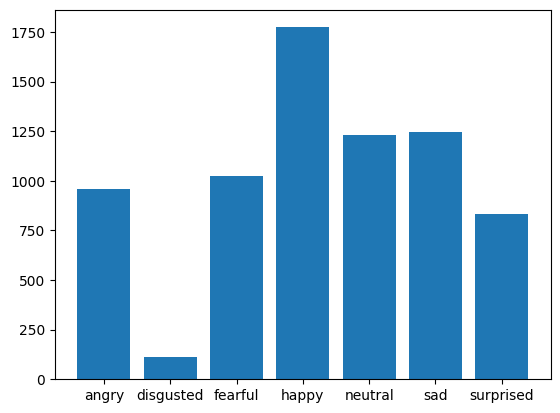

In [ ]:
# TEST 이미지 분포 조회
plot_bar_chart_diagram(test_dir)

In [ ]:
# 이미지 전처리(ImageDataGenerator)
# 데이터를 불러오는 동시에 여러가지 전처리를 쉽게 구현해주는 tf.keras 기능
"""
Data Augmentation
--------------------------
rotation_range = rotates the image with the amount of degrees we provide
width_shift_range = shifts the image randomly to the right or left along the width of the image
height_shift range = shifts image randomly to up or below along the height of the image
horizontal_flip = flips the image horizontally
rescale = to scale down the pizel values in our image between 0 and 1
zoom_range = applies random zoom to our object
validation_split = reserves some images to be used for validation purpose
"""

train_datagen = ImageDataGenerator(rotation_range = 20,  # 이미지 회전
                                         width_shift_range = 0.1,   # 이미지 너비를 따라 오른쪽 혹은 왼쪽으로 무작위 이동
                                         height_shift_range = 0.1,  # 이미지 높이를 따라 위 혹은 아래로 무작위 이동
                                         shear_range=0.1,           # 이미지를 찌그러트리는 정도
                                         horizontal_flip = True,    # 이미지 수평으로 뒤집기(가로축 랜덤 설정)
                                         rescale = 1./255,          # 이미지의 픽셀값을 0에서 1사이로 축
                                         zoom_range = 0.2,         # 무작위로 축소/확대 적용
                                         validation_split = 0.2     # 유효성 검사를 목적으로 사용할 일부 이미지 예약
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,           # validation에도 이미지 전처리 적용
                                         validation_split = 0.2)


In [ ]:
# 클래스 가중치 계산
class_weights = compute_class_weight(
    'balanced',
    np.unique(train_generator.classes),
    train_generator.classes
)

class_weight = dict(enumerate(class_weights))

In [ ]:
"""
이미지를 불러올 때 이미지 증대 적용
Applying data augmentation to the images as we read
them from their respectivve directories
"""
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"  # ImageDataGenerator에 validation_split이 설정된 경우 데이터의 부분집합 ("training" or "validation").
                                                   )
validation_generator = validation_datagen.flow_from_directory(directory = train_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"   # ImageDataGenerator에 validation_split이 설정된 경우 데이터의 부분집합 ("training" or "validation").
                                                             )



Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


### batch_size
- 일반적으로 32, 64 크기의 mini-batch가 성능에는 가장 좋다고 알려져 있음
- batch size를 줄임으로써 얻는 장점: 필요한 메모리 감소
- batch size를 늘림으로써 얻는 장점: 학습이 안정적

In [ ]:
"""
Modeling


model = Sequential()
model.add(Conv2D(filters = 64,kernel_size = (3,3),padding = 'same',activation = 'relu',input_shape=(img_size,img_size,1)))
model.add(MaxPool2D(pool_size = 2,strides = 2))
model.add(BatchNormalization())

model.add(Conv2D(filters = 128,kernel_size = (3,3),padding = 'same',activation = 'relu'))
model.add(MaxPool2D(pool_size = 2,strides = 2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128,kernel_size = (3,3),padding = 'same',activation = 'relu'))
model.add(MaxPool2D(pool_size = 2,strides = 2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters = 256,kernel_size = (3,3),padding = 'same',activation = 'relu'))
model.add(MaxPool2D(pool_size = 2,strides = 2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(units = 128,activation = 'relu',kernel_initializer='he_normal'))
model.add(Dropout(0.25))
model.add(Dense(units = 64,activation = 'relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(units = 32,activation = 'relu',kernel_initializer='he_normal'))
model.add(Dense(7,activation = 'softmax'))

"""

"\nModeling\n\n\nmodel = Sequential()\nmodel.add(Conv2D(filters = 64,kernel_size = (3,3),padding = 'same',activation = 'relu',input_shape=(img_size,img_size,1)))\nmodel.add(MaxPool2D(pool_size = 2,strides = 2))\nmodel.add(BatchNormalization())\n\nmodel.add(Conv2D(filters = 128,kernel_size = (3,3),padding = 'same',activation = 'relu'))\nmodel.add(MaxPool2D(pool_size = 2,strides = 2))\nmodel.add(BatchNormalization())\nmodel.add(Dropout(0.25))\n\nmodel.add(Conv2D(filters = 128,kernel_size = (3,3),padding = 'same',activation = 'relu'))\nmodel.add(MaxPool2D(pool_size = 2,strides = 2))\nmodel.add(BatchNormalization())\nmodel.add(Dropout(0.25))\n\nmodel.add(Conv2D(filters = 256,kernel_size = (3,3),padding = 'same',activation = 'relu'))\nmodel.add(MaxPool2D(pool_size = 2,strides = 2))\nmodel.add(BatchNormalization())\n\nmodel.add(Flatten())\nmodel.add(Dense(units = 128,activation = 'relu',kernel_initializer='he_normal'))\nmodel.add(Dropout(0.25))\nmodel.add(Dense(units = 64,activation = 'relu'

In [ ]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

In [ ]:
epochs = 60
batch_size = 64

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

In [ ]:
# 모델 훈련(oversampling 적용 후)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 64,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 64,
    class_weight=class_weight  # 클래스 가중치 적용
)

In [ ]:
# %%time
# history = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator)

Epoch 1/60
338/359 [===========================>..] - ETA: 15:54 - loss: 9.3631 - accuracy: 0.1909

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
model.save('model_classweight.h5')

In [ ]:
img = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/test/happy/im100.png",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape) #prints (48,48) that is the shape of our image

In [ ]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [ ]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)

In [ ]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()

In [ ]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

In [ ]:
model.save_weights('model_classweight_weights.h5')